In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Number of time steps in one epoch
n = 2100 

data_file_df_list = []
epoch_offset = 0
for data_file in ['output.csv','output_2.csv','output_3.csv']:
    data_file_df = pd.read_csv(data_file)
    data_file_df['epoch'] = epoch_offset + data_file_df.index // n 
    epoch_offset = data_file_df['epoch'].max() + 1
    data_file_df_list.append(data_file_df)

data = pd.concat(data_file_df_list).reset_index()

data['log_response_time'] = np.log(data['response_time'])
CPU_COST = 0.031611
RAM_COST = 0.004237
data['cost'] = (data['cpu_usage']*CPU_COST + data['memory_usage']*RAM_COST)*data['replica']

epoch_boundaries = data[data['epoch'] - data['epoch'].shift() == 1].index

# Load Profile
To train the agent in a an environment similar to production environments, we collected the daily transaction load of our live systems and generated a load profile. We, then, normalized the profile so that it fits to the capacity of the testing environment of the agent. In figure below, the final load profile is shown. 

Text(0.5, 0, 'time index')

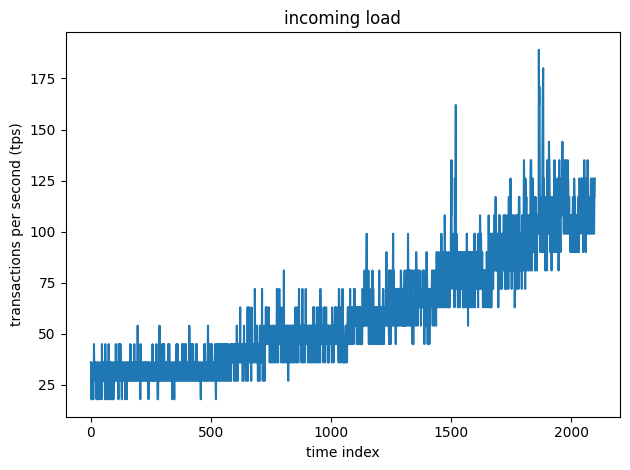

In [2]:
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True)
fig.set_tight_layout(True)
ax.plot(data.loc[:n-1,'expected_tps'])
ax.set_title('incoming load')
ax.set_ylabel('transactions per second (tps)')
ax.set_xlabel('time index')


# Resolution and Repeating
In the load profile we generated above, there are 2100 data points corresponding to almost 6 years of real-data in daily resolution. It is obvious that training the agent in a daily fashion is not feasible. Instead, we wait only a minute between actions. So, training the agent on this load profile requires almost 35 hours. After 2100 actions, we rewind the load profile to the beginning and resume training. 

When the agent finishes a load profile and starts over, we say it enters a new epoch. In the figure below, there are five epochs. Please note that the third epoch is short because there was an unexpected infrastructure failure during training, so the training had to start from the beginning of the load profile. The last (fifth) epoch is unfinished because the training is still going on.


(0.0, 13277.0)

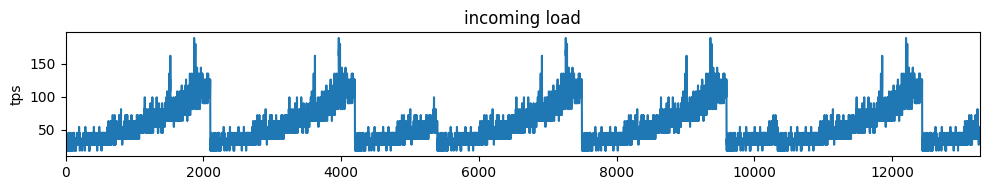

In [3]:
fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True, figsize=(10,2))
fig.set_tight_layout(True)
axes.plot(data['expected_tps'])
axes.set_title('incoming load')
axes.set_ylabel('tps')
axes.set_xlim((0, len(data)))


# Evolution of response time
One the first metrics to look at when trying to understand whether the agent is training well is the response time. If we don't touch any of the setting of an application, we should expect more of less the same response time behaviour under the same load. Contrary, if we fine tune the application, we should expect a significant decrease in response time distribution.  Therefore, if our agent is training well, then it must be able to arrange the settings of the application, hence it should decrease the response time when the application face the same load profile. 

This figure below displays the expected behaviour. On top, we display the complete load profile used in the training. On bottom, response times of the application are shown.  As you see, the outliers are becoming rare even if the same load profile is applied. This is an indication that the agent learns to choose settings to lower than the response times.



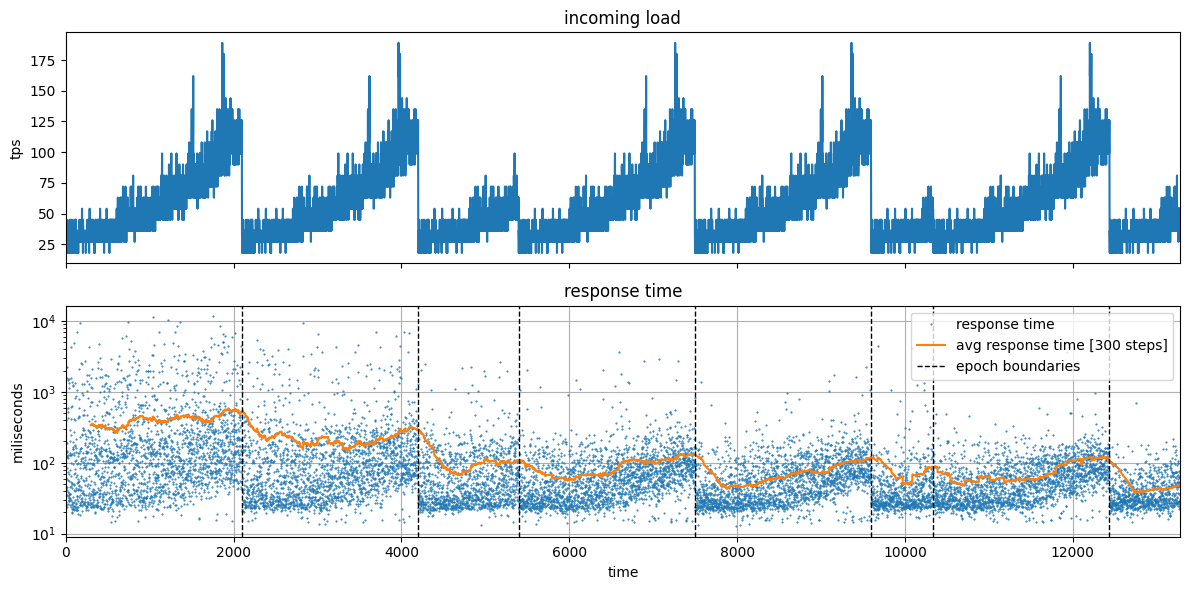

In [4]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(12,6),sharex=True)
fig.set_tight_layout(True)
axes[0].plot(data['expected_tps'])
axes[0].set_title('incoming load')
axes[0].set_ylabel('tps')
axes[0].set_xlim((0, len(data)))

avg_response_time = pd.Series(data['response_time']).rolling(300).mean()

axes[1].plot(data['response_time'],'.',markersize=1,label='response time')
axes[1].plot(avg_response_time, label='avg response time [300 steps]')
for epoch, epoch_boundary in zip(range(len(epoch_boundaries)), epoch_boundaries):
    axes[1].axvline(x=epoch_boundary, color='k', linestyle='--', linewidth=1, label='epoch boundaries' if epoch == 0 else None)
axes[1].set_yscale('log')
axes[1].set_xlabel('time')
axes[1].set_title('response time')
axes[1].set_ylabel('miliseconds')
axes[1].grid(True)
axes[1].legend()
plt.show()

# Epoch vs Response time 
Another way to display the effect of the agent on the response time, we aggregate the response times with respect to epochs and display the response times as box plots. The first epoch corresponds to the first time the agent is faced to the load profile. 

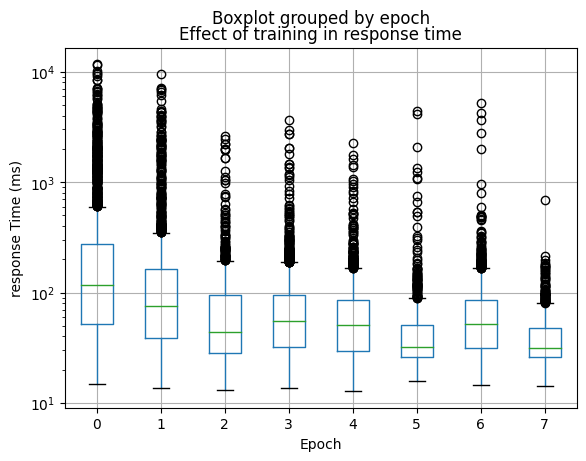

In [5]:
data.boxplot(by='epoch', column='response_time')
plt.xlabel('Epoch')
plt.ylabel('response Time (ms)')
plt.yscale('log')
plt.title('Effect of training in response time')
plt.show()

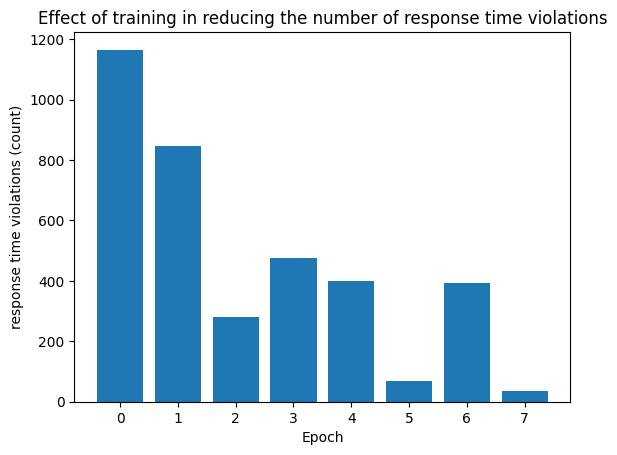

In [6]:
response_time_violations = data[data['response_time'] > 100].groupby('epoch').agg({'response_time':'count'}).reset_index()
plt.bar(response_time_violations['epoch'], response_time_violations['response_time'])

plt.xlabel('Epoch')
plt.ylabel('response time violations (count)')
plt.yscale('linear')
plt.title('Effect of training in reducing the number of response time violations')
plt.show()


# Monitoring Reward
If our agent is training well, then the agent should learn to get high rewards as time passes. Let's draw step vs reward plot to see this. 
Red vertical lines correspond to the epoch boundaries.

* By design, we put an upper limit for reward and this boundary is visible in the plot.
* As time passes, rewards are getting better.
* At the end of each epoch, reward is dropped possibly because of increased load.

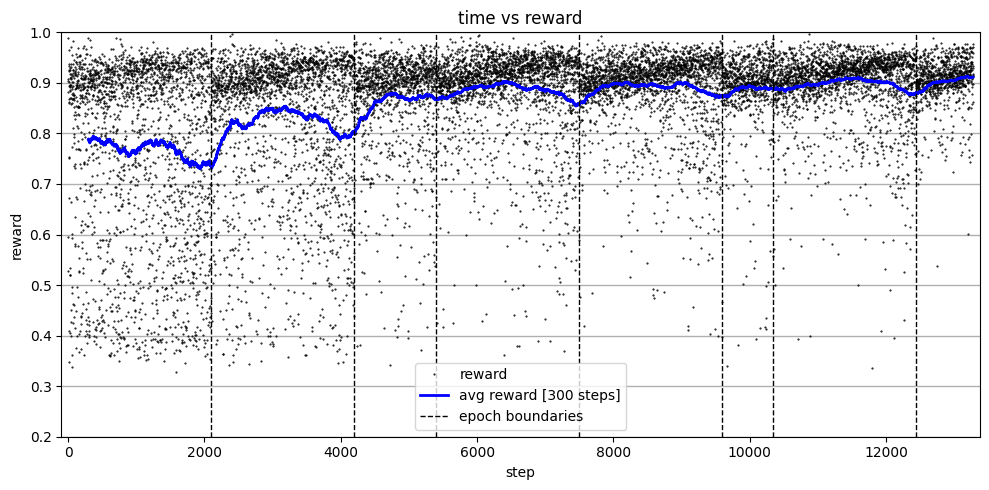

In [7]:
avg_reward = pd.Series(data['reward']).rolling(300).mean()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5),sharex=True)
fig.set_tight_layout(True)
ax.plot(data['reward'], '.', label="reward", markersize=1, color='k')
ax.plot(avg_reward,label='avg reward [300 steps]', linewidth=2,color='b')
ax.set_xlabel('step')
ax.set_ylabel('reward')
ax.set_title('time vs reward')
ax.yaxis.grid(True,  lw = 1)
ax.set_yscale('linear')
ax.set_axisbelow(True)
ax.set_ylim([0.2,1])
ax.set_xlim([-100,len(data)+100])
for epoch, epoch_boundary in zip(range(len(epoch_boundaries)), epoch_boundaries):
    ax.axvline(x=epoch_boundary, color='k', linestyle='--', linewidth=1, label='epoch boundaries' if epoch == 0 else None)
ax.legend()
plt.show()

# Performance: showing the ability to process incoming traffic
Let's look at the difference between the instance and expected tps (transactions per second). Expected tps is the incoming web traffic that we know in advance. Instant tps is the actual incoming tps measured from Prometheus metric storage. If the difference is negative then we know the application can not process all of the incoming requests. If it is non-negative, then the application process all of the incoming traffic plus some extra traffic left in queue. In a healthy system, we expect the difference fluctuate in a tight band around zero.

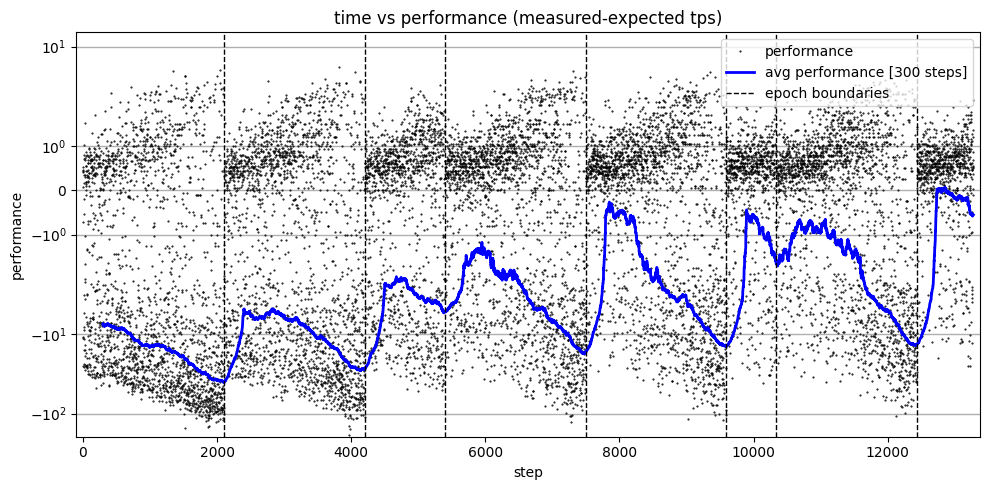

In [8]:
data['performance'] = data['instant_tps']-data['expected_tps']
avg_performance = pd.Series(data['performance']).rolling(300).mean()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5),sharex=True)
fig.set_tight_layout(True)
ax.plot(data['performance'],'.', label="performance", markersize=1, color='k')
ax.plot(avg_performance,label='avg performance [300 steps]', linewidth=2,color='b')
ax.set_xlabel('step')
ax.set_ylabel('performance')
ax.set_title('time vs performance (measured-expected tps)')
ax.yaxis.grid(True,  lw = 1)
ax.set_axisbelow(True)
ax.set_xlim([-100,len(data)+100])
ax.set_yscale('symlog')
for epoch, epoch_boundary in zip(range(len(epoch_boundaries)), epoch_boundaries):
    ax.axvline(x=epoch_boundary, color='k', linestyle='--', linewidth=1, label='epoch boundaries' if epoch == 0 else None)
ax.legend()
plt.show()

# Another look at performance
As you see from the above figure, our custom performance metric fluctuates around zero leaning to positive side as we train the agent further. However, there is a scale difference. If the application runs poorly, the performance can drop to around -100 tps. On the other hand, when the application is working well, the performance can rise only about to 10 tps. The reason is that the rate of processed transactions is natually limited by the incoming transaction load. The application can not be expected to process more transactions then it has unless there are some extra leftover transactions from previous steps. On the other hand, the application can fail badly for instance there could be times where it can not consume any of the workload leading -100 tps performance. In summary, there is an asymmetric evaluation when we interpret good/bad performance. 

To get rid of this asymmetry, I recommend to look at the sign of the performance metric. By looking at the sign of the performance attribute (which is instant tps minus expected tps), we can remove the scaling issue and focus on more how times the application was able to consume all of incoming traffic. 

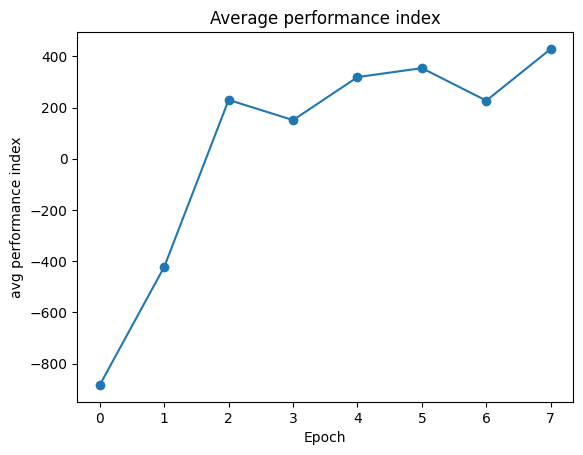

In [9]:
data['performance_index'] = data['performance'].apply(np.sign)
tmp_df = data.groupby('epoch').agg({'performance_index':'sum'}).reset_index()
plt.plot(tmp_df['epoch'],tmp_df['performance_index'],'o-')
plt.xlabel('Epoch')
plt.ylabel('avg performance index')
plt.yscale('linear')
plt.title('Average performance index')
plt.show()


# Sensitivity Analysis
Here, I'll do sensitivity analysis similar to the analysis on (https://dergipark.org.tr/en/download/article-file/2326144). I take three inputs: replica, cpu and heap. And two different outputs: performance and cost. The kind of plot I'm going to create is also called partial dependency plot. In the function below, we first calculate the average output denoted by f0. Then by aggregating the outputs on distinct metric values, we obtain partial dependency plots.

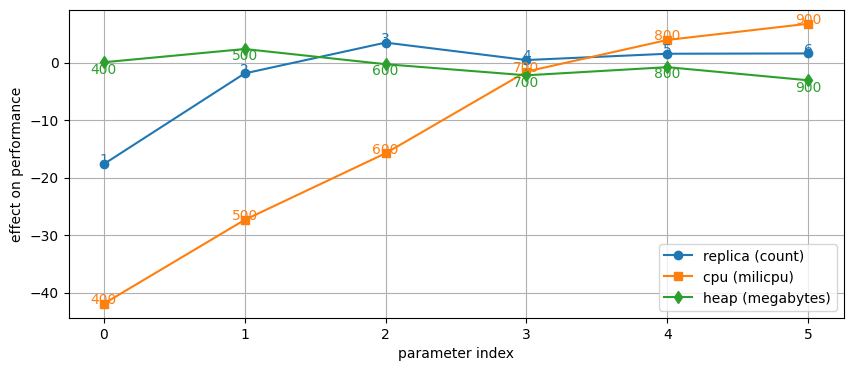

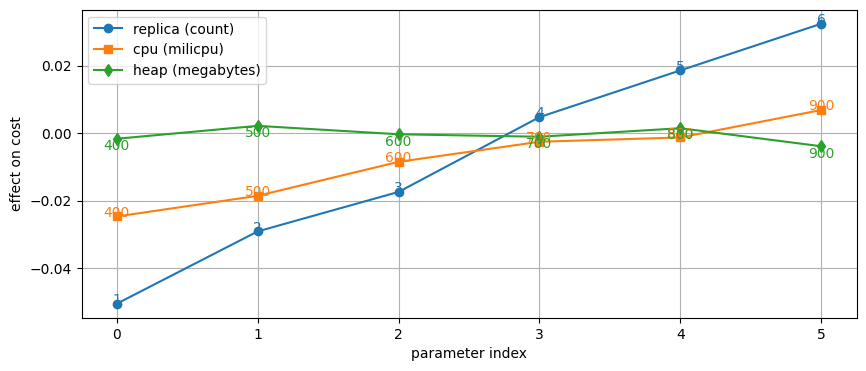

In [10]:
output_criteria = 'performance'

def plot_pdp(output_criteria):
    f0 = data[output_criteria].mean()
    # f1: replica vs output
    f1 = data[['replica',output_criteria]].groupby('replica').agg({output_criteria:'mean'}).reset_index()
    f1[output_criteria] = f1[output_criteria] - f0

    # f2: cpu vs output
    f2 = data[['cpu',output_criteria]].groupby('cpu').agg({output_criteria:'mean'}).reset_index()
    f2[output_criteria] = f2[output_criteria] - f0

    # f3: heap vs output
    f3 = data[['heap',output_criteria]].groupby('heap').agg({output_criteria:'mean'}).reset_index()
    f3[output_criteria] = f3[output_criteria] - f0

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,4))
    ax.plot(f1[output_criteria],'o-',label='replica (count)', color='#1f77b4')
    for i, row in f1.iterrows():
        ax.text(i, row[output_criteria], f'{row["replica"]:.0f}', ha="center",color='#1f77b4')
    ax.plot(f2[output_criteria],'s-',label='cpu (milicpu)', color='#ff7f0e')
    for i, row in f2.iterrows():
        ax.text(i, row[output_criteria], f'{100*row["cpu"]:.0f}', ha="center", color='#ff7f0e')
    ax.plot(f3[output_criteria],'d-',label='heap (megabytes)', color='#2ca02c')
    for i, row in f3.iterrows():
        ax.text(i, row[output_criteria], f'{100*row["heap"]:.0f}', ha="center",color='#2ca02c', va="top")
    ax.grid()
    ax.legend()
    ax.set_xlabel('parameter index')
    ax.set_ylabel(f'effect on {output_criteria}')


# PDPs for performance
plot_pdp('performance')
# PDPs for cost
plot_pdp('cost')


# Presentation of the test results acquired by agent trained with PPO algorithm

In [12]:
df_test_test_results = pd.read_csv("test_results.csv")

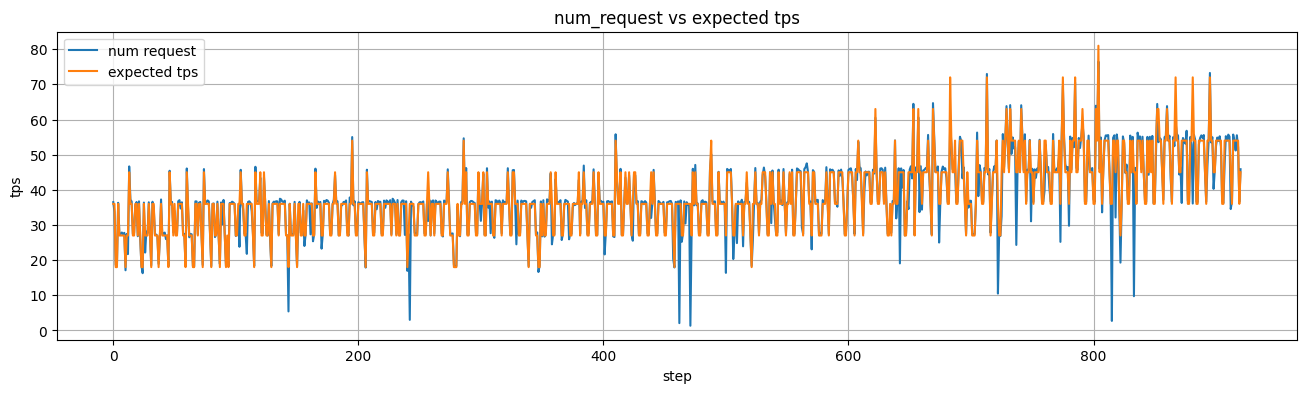

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(df_test_test_results["num_request"], label="num request")
ax.plot(df_test_test_results["expected_tps"], label="expected tps")
ax.set_xlabel("step")
ax.set_ylabel("tps")
ax.set_title("num_request vs expected tps")
ax.grid()
ax.legend()
plt.show()


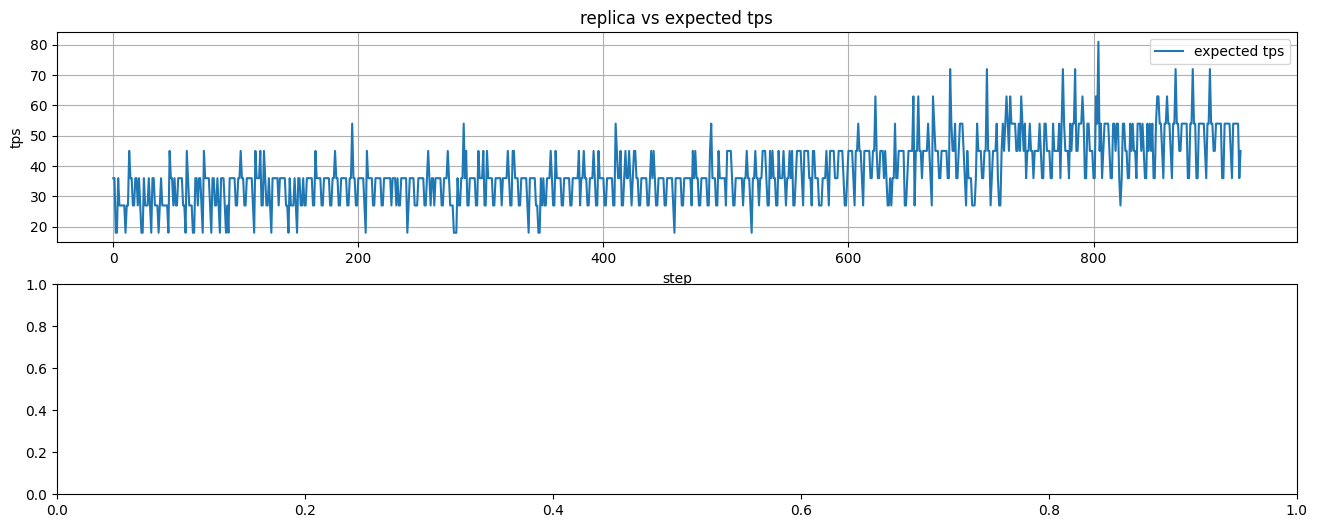

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6))
ax[0].plot(df_test_test_results["expected_tps"], label="expected tps")
ax[0].set_xlabel("step")
ax[0].set_ylabel("tps")
ax[0].set_title("replica vs expected tps")
ax[0].grid()
ax[0].legend()






plt.show()

In [36]:
df_test_test_results["expected_tps"].min()

18

In [119]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go



def plotly_multi(data):

    number_of_columns = data.shape[1]


    if number_of_columns==2:
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        fig.add_trace(
            go.Scatter(x=data.index, y=data.iloc[:, 0], name=data.columns[0]),
            secondary_y=False,)
        fig.add_trace(
            go.Scatter(x=data.index, y=data.iloc[:, 1], name=data.columns[1]),
            secondary_y=True,)
        fig.update_xaxes(title_text="Date")
        fig.update_yaxes(title_text=data.columns[0], secondary_y=False)
        fig.update_yaxes(title_text=data.columns[1], secondary_y=True)
    

    if number_of_columns>2:
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(x=data.index, y=data.iloc[:, 0], name=data.columns[0]))
    
        fig.update_layout(
            xaxis=dict(domain=[0.1, 0.9]),
            yaxis=dict(title=data.columns[0]),
            yaxis2=dict(title=data.columns[1], anchor="x", overlaying="y", side="right"))
    
        for i, col in enumerate(data.columns[1:], 1):
            fig.add_trace(
                go.Scatter(x=data.index,y=data[col],name=col,yaxis=f"y{i+1}"))
    
        for i, col in enumerate(data.columns[2:], 2):
            axis = f"yaxis{i+1}"
    
            if i%2 == 0:
                side = "left"
                position = (i-1)*0.025
            else:
                side = "right"
                position = 1 - (i-2)*0.025
    
            axis_value = dict(
                title=col,
                anchor="free",
                overlaying="y",
                side=side,
                position=position)
            exec(f"fig.update_layout({axis} = {axis_value})")



    
    fig.update_layout(title_text="Data",width=1100)
    
    fig.show()


plot_metrics = ["replica", "cpu", "heap", "expected_tps"]
plotly_multi(df_test_test_results[plot_metrics])

